<a href="https://colab.research.google.com/github/tuftsdatalab/segment-anything-geo/blob/main/Segmenting_Imagery_with_Segement_Anything_Model_(SAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

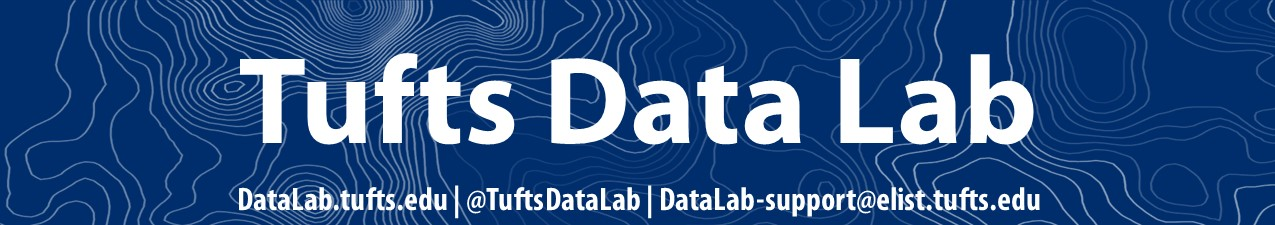

# **Segmentation and Object Identification with Text Prompts - SAMGEO**

Written by Chad Fisher 2/20/25

This is a Tufts University Data Lab geospatial notebook based tutorial. You can use it in 2 ways:
1. Use it directly in Google Colab using your Google Account as you are now. You have to make a copy of it to save your work. To make a copy, click on:  ```File -> Save a Copy in Drive ```
2. (**Not** recommended, because need GPU) You can download the tutorial and run it in any python notebook environment, including Jupyter, Spyder, Positron, etc. You may have to install packages that are already installed in Colab and/or have limited functionality as the tutorial has been designed for Colab. To download the tutorial notebook, click on ```File -> Download -> Download .ipynb ```

## Introduction

In this tutorial, we will use drone imagery collected in the morning and afternoon of geese on **????** pond to explore the capabilities of an image segmentation foundation model from Meta AI called [*Segment Anything Model (SAM)*](https://ai.meta.com/blog/segment-anything-foundation-model-image-segmentation/).

**Segmentation** is a core task in computer vision and is the identification of distinct objects and the classification of image pixels to these unique objects. Creating an accurate model for specific tasks typically requires extensive technical expertise, complex infrastructure, and large datasets. SAM aims to create a *foundation model*, which means a model that is generally applicable to many different tasks and comes pre-trained.

Using the [**segment-geospatial**](https://www.google.com/url?q=https%3A%2F%2Fsamgeo.gishub.org%2F) python package, we will learn to:
1. Initialize the model to use various text prompts to identify objects in a drone image
2. Compare the effects of illumination and lighting in a drone image on segmentation accuracy
3. Fine-tune model paramaters including the text threshold, box threshold, and tiling size


## 1. Change the runtime and install dependencies

Image segmentation tasks can be computationally intensive and are often sped up by the use of a *GPU (graphical processing unit)* which is uniquely suited for these tasks.



1. Change the runtime to the **T4 GPU** in the top right corner of Google Colab.

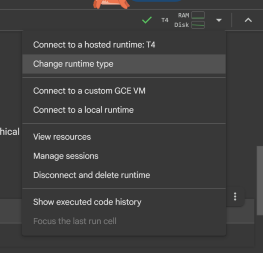

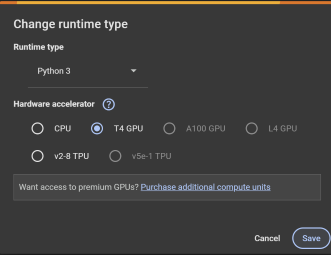

2. Your runtime should now look like this:

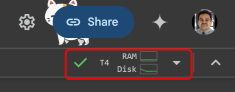

3. Uncomment (remove the # at the beginning) and run the following cell to install the required dependencies. ***This might take a while (~6 mins) so be patient :) and consider reading up on the model with the links in the introduction***

*Note: if you see a warning that says 'This Notebook was not authored by Google,' click Run Anyway*


In [ ]:
%pip install segment-geospatial groundingdino-py leafmap localtileserver

4. When the installation completes, you will have to restart the runtime. Click accept on the popup that appears. Don't worry, we haven't created any variables so nothing will get deleted!

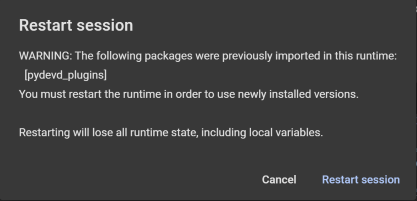

5. Now import the packages:

In [1]:
import leafmap # This is an interactive mapping widget for python
from samgeo import tms_to_geotiff, split_raster # These are the functions for downloading satellite imagery and tiling data
from samgeo.text_sam import LangSAM # This is the function for initializing the model

## 2. Download Drone Imagery

1. This text enables our interactive widgets with Colab and only needs to be run once.

In [10]:
from google.colab import output
output.enable_custom_widget_manager()

2. We will be using 2 previously collected drone images of **??** that can be downloaded from box.

In [2]:
import urllib.request # Library for downloading from URLs
morning_URL='https://tufts.box.com/shared/static/1dmkvzoxxccnvvzwiol4bxr7qv0xx4zz.tif'
afternoon_URL=''
urllib.request.urlretrieve(morning_URL, "morning.tif") #Download image as morning.tif

('morning.tif', <http.client.HTTPMessage at 0x7e771909c350>)

3. Create a new interactive map centered on our new imagery at XXXX N, XXXX W

In [8]:
m = leafmap.Map(center=[-22.1278, -51.4430], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[-22.1278, -51.443], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

4. Add the downloaded image and explore it interactively. What do you notice? How many geese do you see?

In [9]:
m.layers[-1].visible = False
m.add_raster('morning.tif', layer_name="Image")
m

Map(bottom=18893345.0, center=[42.449507, -72.683637], controls=(ZoomControl(options=['position', 'zoom_in_tex…

## 3. Initialize the Default Model on the Morning Image

We will now initialize the SAM model on our morning image with the default settings and try a few different text prompts including geese, bird, waterfowl, and duck.

1. Initialize the model with the following code. This also might take a while, but will only need to be done once! The initialization downloads the model weights and sets up the model for inference.

In [11]:
sam = LangSAM()

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:18<00:00, 138MB/s]


2. Specify text prompts:

In [12]:
P1 = "geese"
P2 = 'goose'
P3 = 'bird'
P4 = 'waterfowl'
P5 = 'duck'
P6 = '' #choose your own text prompt that is not in the image (i.e., skyscraper)

3. Segment the image with the defaults. We will experiment with changing the parameters later in this tutorial:

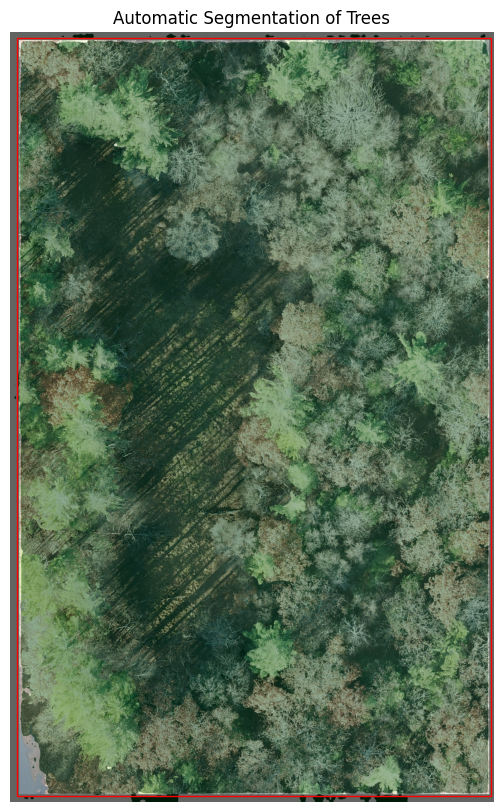

In [25]:
sam.predict(image="morning.tif",
            text_prompt='grass',
            box_threshold=0.5,
            text_threshold=0.24)
sam.show_anns(
    cmap="Greens",
    box_color="red",
    title="Automatic Segmentation of Trees",
    blend=True,
)

Questions for Jon:


1.   Where does he want the lab to focus on?
2.   What methods does he want to explore? Text prompts? Unsupervised automatic mask generation? Tree mapping? Understanding what the different parameters do? Does he want to tile the imagery? Satellite imagery or drone imagery or both?



Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

# Conclusion